# Project Overview
# 🏥 Patient Readmission Prediction

**Objective:** Predict hospital readmissions based on patient demographics, diagnosis, and hospital stay details.  
**Target Variable:** `Readmitted` (Yes=1, No=0)  



1.Import Libraries & Load Data



In [5]:
#1.Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib


In [9]:
#Synthetic dataset to CSV
np.random.seed(42)
n = 5000
ages = np.random.choice(['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80+'], n, p=[0.02,0.03,0.12,0.15,0.15,0.18,0.18,0.1,0.07])
gender = np.random.choice(['Male','Female'], n)
admission = np.random.choice(['Emergency','Elective','Urgent'], n, p=[0.55,0.25,0.20])
diagnoses = np.random.choice(['Diabetes','Hypertension','Heart Failure','COPD','Pneumonia','Renal Failure','Other'], n)
los = np.clip((np.random.exponential(scale=4, size=n).astype(int) + 1),1,60)
labs = np.random.poisson(10, n)
meds = np.random.poisson(6, n)
prev = np.random.poisson(0.7, n)
dispo = np.random.choice(['Home','Transfer','Nursing Facility'], n, p=[0.8,0.1,0.1])
# Make readmission correlated with age, diagnosis, prev, LOS
prob = (np.where(np.isin(ages, ['70-79','80+']),0.12,0.05) +
        np.where(diagnoses=='Heart Failure',0.18,0) +
        (prev*0.05) + (los*0.01))
prob = np.clip(prob, 0, 0.6)
readmitted = np.where(np.random.rand(n) < prob, 'Yes', 'No')

df = pd.DataFrame({
    'PatientID': np.arange(1,n+1),
    'Age': ages,
    'Gender': gender,
    'AdmissionType': admission,
    'PrimaryDiagnosis': diagnoses,
    'LengthOfStay': los,
    'NumLabProcedures': labs,
    'NumMedications': meds,
    'PreviousAdmissions': prev,
    'DischargeDisposition': dispo,
    'Readmitted': readmitted
})

df.to_csv('patients.csv', index=False)

df = pd.read_csv("patients.csv")
df.head()

,PatientID,Age,Gender,AdmissionType,PrimaryDiagnosis,LengthOfStay,NumLabProcedures,NumMedications,PreviousAdmissions,DischargeDisposition,Readmitted
0,1,40-49,Male,Emergency,Heart Failure,3,9,7,0,Home,No
1,2,80+,Female,Urgent,Renal Failure,1,10,11,0,Home,No
2,3,60-69,Male,Emergency,Other,5,14,6,1,Nursing Facility,No
3,4,50-59,Female,Emergency,COPD,8,13,6,0,Home,No
4,5,20-29,Female,Elective,Pneumonia,6,8,3,0,Nursing Facility,No


2. Quick Data Overview

In [10]:
df.info()
df.describe(include="all")
df['Readmitted'].value_counts(normalize=True)

# Convert target to binary
df['Readmitted'] = df['Readmitted'].map({'Yes':1, 'No':0})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PatientID             5000 non-null   int64 
 1   Age                   5000 non-null   object
 2   Gender                5000 non-null   object
 3   AdmissionType         5000 non-null   object
 4   PrimaryDiagnosis      5000 non-null   object
 5   LengthOfStay          5000 non-null   int64 
 6   NumLabProcedures      5000 non-null   int64 
 7   NumMedications        5000 non-null   int64 
 8   PreviousAdmissions    5000 non-null   int64 
 9   DischargeDisposition  5000 non-null   object
 10  Readmitted            5000 non-null   object
dtypes: int64(5), object(6)
memory usage: 429.8+ KB


3. Missing Values & Cleaning

In [11]:
df.isna().sum()

# (Example: if Age has missing values, impute with mode)
df['Age'] = df['Age'].fillna(df['Age'].mode()[0])


4. Exploratory Data Analysis (EDA)

In [12]:
# Readmission Rate
rate = df['Readmitted'].mean()
print(f"Overall Readmission Rate: {rate:.2%}")


Overall Readmission Rate: 17.04%


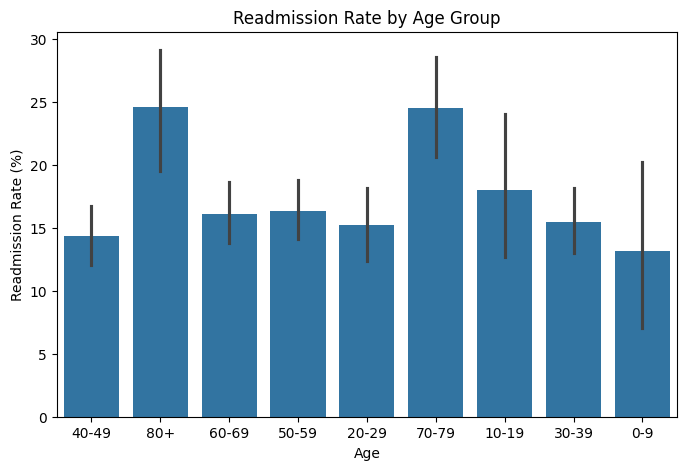

In [13]:
# Readmission by Age
plt.figure(figsize=(8,5))
sns.barplot(x='Age', y='Readmitted', data=df, estimator=lambda x: np.mean(x)*100)
plt.ylabel("Readmission Rate (%)")
plt.title("Readmission Rate by Age Group")
plt.show()


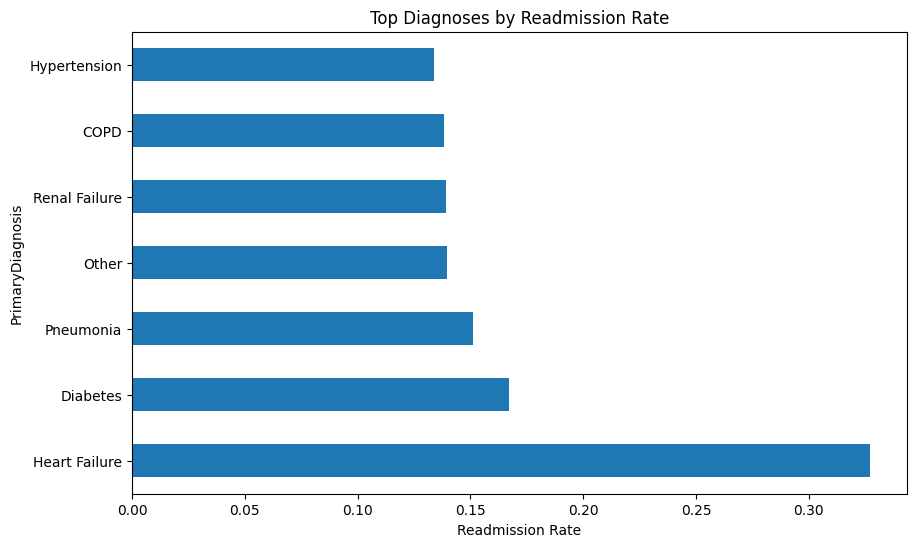

In [14]:
# Readmission by Primary Diagnosis
plt.figure(figsize=(10,6))
df.groupby('PrimaryDiagnosis')['Readmitted'].mean().sort_values(ascending=False).plot(kind='barh')
plt.xlabel("Readmission Rate")
plt.title("Top Diagnoses by Readmission Rate")
plt.show()


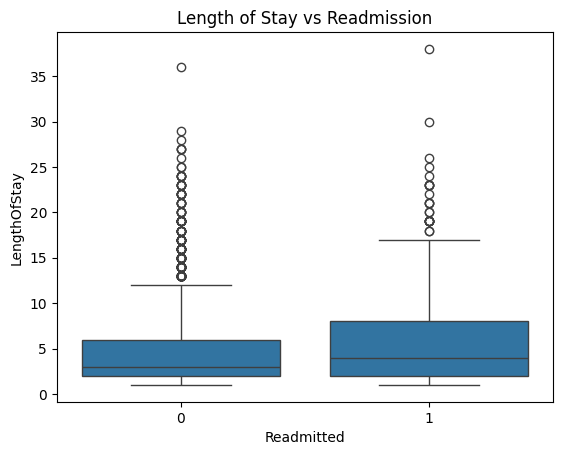

In [15]:
# Avg Length of Stay for Readmitted vs Not
sns.boxplot(x='Readmitted', y='LengthOfStay', data=df)
plt.title("Length of Stay vs Readmission")
plt.show()


5. Feature Engineering

In [16]:
# Create engineered features
df['is_emergency'] = (df['AdmissionType'] == 'Emergency').astype(int)
df['long_stay'] = (df['LengthOfStay'] > 7).astype(int)
df['prev_bin'] = pd.cut(df['PreviousAdmissions'], bins=[-1,0,2,10], labels=['0','1-2','3+'])

# Drop PatientID (not predictive)
df = df.drop(columns=['PatientID'])


6. Define Features & Preprocessing

In [17]:
X = df.drop(columns=['Readmitted'])
y = df['Readmitted']

num_cols = ['LengthOfStay','NumLabProcedures','NumMedications','PreviousAdmissions']
cat_cols = ['Age','Gender','AdmissionType','PrimaryDiagnosis','DischargeDisposition','prev_bin']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


7. Train-Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


8. Baseline Model — Logistic Regression



In [19]:
pipe_lr = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))


              precision    recall  f1-score   support

           0       0.88      0.66      0.75       830
           1       0.25      0.56      0.35       170

    accuracy                           0.64      1000
   macro avg       0.56      0.61      0.55      1000
weighted avg       0.77      0.64      0.68      1000

ROC AUC: 0.6411126860382708


9. Random Forest Model

In [20]:
pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       0.83      0.97      0.90       830
           1       0.18      0.03      0.05       170

    accuracy                           0.81      1000
   macro avg       0.50      0.50      0.47      1000
weighted avg       0.72      0.81      0.75      1000

ROC AUC: 0.614053862508859


10. XGBoost Model

In [21]:
pipe_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=3  # handle imbalance
    ))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85       830
           1       0.26      0.25      0.26       170

    accuracy                           0.76      1000
   macro avg       0.56      0.55      0.55      1000
weighted avg       0.75      0.76      0.75      1000

ROC AUC: 0.5955138199858256


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


11. Model Comparison

In [22]:
roc_scores = {
    "Logistic Regression": roc_auc_score(y_test, y_proba_lr),
    "Random Forest": roc_auc_score(y_test, y_proba_rf),
    "XGBoost": roc_auc_score(y_test, y_proba_xgb)
}
roc_scores


{'Logistic Regression': np.float64(0.6411126860382708),
 'Random Forest': np.float64(0.614053862508859),
 'XGBoost': np.float64(0.5955138199858256)}

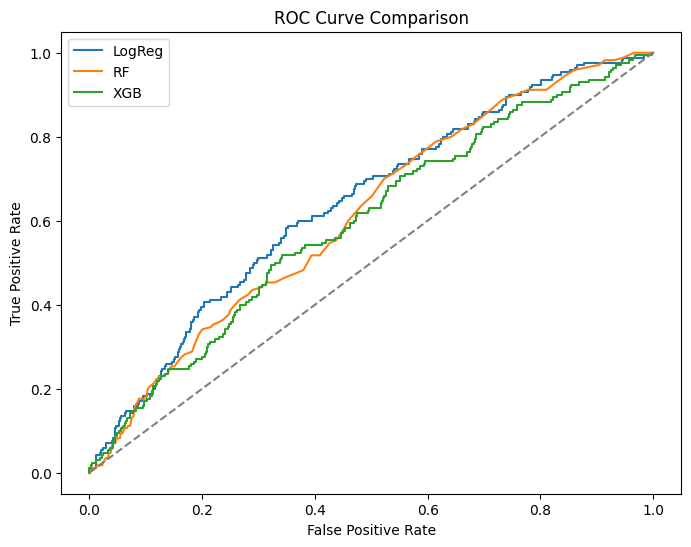

In [23]:
# Plot ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="RF")
plt.plot(fpr_xgb, tpr_xgb, label="XGB")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()


12. Feature Importance (Random Forest)

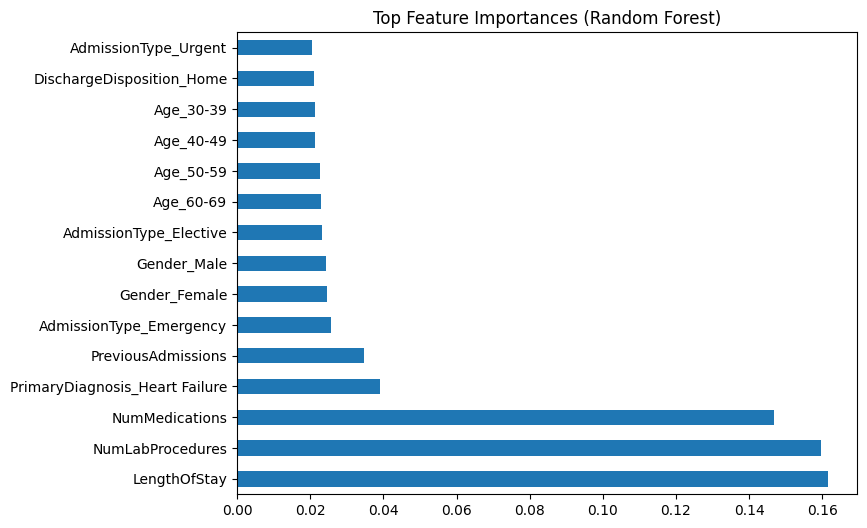

In [24]:
# Get feature names
ohe_features = pipe_rf.named_steps['preprocess'].transformers_[1][1]['onehot'].get_feature_names_out(cat_cols)
all_features = num_cols + list(ohe_features)

importances = pipe_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Top Feature Importances (Random Forest)")
plt.show()


13. Save Best Model

In [26]:
joblib.dump(pipe_xgb, "readmission_model_v1.joblib")
print("Model saved!")


Model saved!


14. Conclusion
### ✅ Key Findings
- Higher **PreviousAdmissions** and longer **LengthOfStay** strongly predict readmission.
- **Heart Failure** and **Renal Failure** diagnoses had the highest risk.
- XGBoost performed best (highest ROC-AUC).
